In [254]:
import featurization
import helpers
import model_bayesian
import model_neighbors

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

%reload_ext autoreload
%autoreload 2

In [169]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import datetime

In [5]:
geodf = featurization.all_featurization_keep_recharges("all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


In [99]:
one_bike = geodf.iloc[7928]


In [137]:
def get_mean_interarrival_time(one_bike, geodf):
    neighbors = model_neighbors.get_nearest_neighbor_bikes(one_bike, geodf, 1000)
    neighbor_df = geodf.loc[neighbors]
    if len(neighbor_df) < 2:
        return 90
    interarrival_times = []
    for date in neighbor_df['local_time_start'].dt.date.unique():
        df = neighbor_df[neighbor_df['local_time_start'].dt.date == date]
        if len(df) < 2:
            interarrival_times.append(90)
        arrival_times = sorted(df['local_time_start'].dt.minute)
        for x in range(len(arrival_times)-1):
            interarrival_times.append(arrival_times[x+1]-arrival_times[x])
    mean_interarrival_time = np.array(interarrival_times).mean()
    return mean_interarrival_time

In [391]:
samp = geodf.iloc[:100]

In [400]:
mean_interarrival = samp.apply(lambda x: model_neighbors.get_mean_interarrival_time(x.geolocation, x.local_time_start, geodf, 1000), axis=1)

In [401]:
mean_interarrival

58      0.228431
59      0.223810
137     0.537037
136     0.197619
256     0.194444
254     0.194444
226     0.191667
218     0.191667
221     0.191667
244     0.191667
234     0.217460
225     0.239744
243     0.239744
317     1.500000
464     0.269444
465     0.283333
461     0.175926
493     1.500000
670     0.570000
677     0.209524
676     0.160000
767     0.407143
762     1.500000
766     0.221569
764     0.198246
896     0.766667
995     0.217949
1028    1.500000
1175    0.183333
1235    0.480000
          ...   
2857    0.225000
2951    0.160606
2998    1.500000
3149    0.217949
3212    0.195833
3213    0.244444
3214    0.528571
3251    0.163542
3302    0.203333
3306    0.513889
3304    0.420000
3363    0.480000
3420    0.610000
3419    0.322727
3423    0.513889
3417    1.500000
3471    1.500000
3577    0.756667
3650    1.500000
3745    0.406250
3799    0.298333
3802    0.302778
3801    0.181481
3798    0.490476
3895    1.500000
3941    0.228431
4001    0.353571
4012    1.5000

In [138]:
(mean_interarrival.apply(len)==1).sum()

16

In [154]:
now = pd.datetime.now()

In [378]:
now.hour*60 + now.minute

865

In [382]:
times = geodf.iloc[:10].local_time_start

In [388]:
model_neighbors.get_mean_interarrival_time(one_bike.geolocation, now, geodf, 1000)

3384    2018-10-31 13:09:14-07:00
11156   2018-10-31 13:00:00-07:00
5565    2018-10-31 15:29:47-07:00
8499    2018-10-31 15:29:47-07:00
Name: local_time_start, dtype: datetime64[ns, America/Los_Angeles]
[13.0, 13.15, 15.483333333333333, 15.483333333333333]
10616   2018-10-24 14:13:18-07:00
5703    2018-10-24 13:37:05-07:00
7625    2018-10-24 13:08:46-07:00
7627    2018-10-24 13:19:55-07:00
Name: local_time_start, dtype: datetime64[ns, America/Los_Angeles]
[13.133333333333333, 13.316666666666666, 13.616666666666667, 14.216666666666667]
[0.15000000000000036, 2.333333333333332, 0.0, 0.18333333333333357, 0.3000000000000007, 0.5999999999999996]


0.5944444444444444

In [215]:
train_geodf = featurization.all_featurization("all-sc-bike-data-1101.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/katelynwalker/galvanize/other_projects/bike-share/featurization.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  idle_df['idle_time'] = idle_df['utc_time_end'] - idle_df['utc_time_start']


Dropping 1 entries where end time was before start time


In [238]:
test_geodf = featurization.all_featurization("bike-data/sc-bike-data-ending1109.csv")

/Users/katelynwalker/galvanize/other_projects/bike-share/featurization.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  idle_df['idle_time'] = idle_df['utc_time_end'] - idle_df['utc_time_start']


Dropping 0 entries where end time was before start time


In [281]:
train_raw = train_geodf.sort_values('utc_time_start', axis=0)
X_raw = train_raw[["lon", "lat", "time_of_day_start", "day_of_week"]]
y = train_raw["idle_hours"]

In [282]:
test_raw = test_geodf.sort_values('utc_time_start', axis=0)
X_test_raw = test_raw[["lon", "lat", "time_of_day_start", "day_of_week"]]
y_test = test_raw["idle_hours"]

In [283]:
scaler = StandardScaler()
scaler.fit(X_raw.astype(float))
X = scaler.transform(X_raw.astype(float))

In [284]:
X_test = scaler.transform(X_test_raw.astype(float))

In [296]:
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
#...    X_train, X_test = X[train_index], X[test_index]

TRAIN: [   0    1    2 ... 1773 1774 1775] TEST: [1776 1777 1778 ... 3547 3548 3549]
TRAIN: [   0    1    2 ... 3547 3548 3549] TEST: [3550 3551 3552 ... 5321 5322 5323]
TRAIN: [   0    1    2 ... 5321 5322 5323] TEST: [5324 5325 5326 ... 7095 7096 7097]


In [297]:
tscv.split(X)

<generator object TimeSeriesSplit.split at 0x1a29f718e0>

In [298]:
model = KNeighborsRegressor()

In [306]:
gcv = GridSearchCV(model, param_grid={"n_neighbors":range(40,70),
                                        "weights":["uniform","distance"]}, 
                   verbose=1,
                   cv=tscv.split(X),
                   error_score=np.nan)

In [307]:
gcv.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   20.8s finished


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x1a29f71eb8>,
       error_score=nan,
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(40, 70), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [309]:
gcv.best_params_

{'n_neighbors': 51, 'weights': 'distance'}

In [295]:
pd.DataFrame(gcv.cv_results_)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001701,0.000314,0.014070,0.001834,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.076835,0.081090,0.077279,...,-0.050666,0.282391,34,0.197945,0.248311,0.258559,0.247676,0.258298,0.242158,0.022595
1,0.001568,0.000456,0.013904,0.002610,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.077318,0.080699,0.077256,...,-0.062210,0.308156,40,0.996609,0.998281,0.998621,0.999014,0.999212,0.998347,0.000927
2,0.001627,0.000364,0.013989,0.002228,21,uniform,"{'n_neighbors': 21, 'weights': 'uniform'}",0.082310,0.083827,0.080322,...,-0.046365,0.280531,30,0.194177,0.247508,0.256941,0.245665,0.256407,0.240140,0.023428
3,0.001823,0.000515,0.014798,0.001934,21,distance,"{'n_neighbors': 21, 'weights': 'distance'}",0.082178,0.084344,0.079833,...,-0.057410,0.304769,38,0.996609,0.998281,0.998621,0.999014,0.999212,0.998347,0.000927
4,0.001606,0.000556,0.014489,0.002000,22,uniform,"{'n_neighbors': 22, 'weights': 'uniform'}",0.083359,0.077064,0.076152,...,-0.048199,0.281391,32,0.186962,0.244991,0.253218,0.241679,0.252959,0.235962,0.024908
5,0.001495,0.000430,0.014114,0.002133,22,distance,"{'n_neighbors': 22, 'weights': 'distance'}",0.083419,0.079184,0.076562,...,-0.057904,0.304018,39,0.996609,0.998281,0.998621,0.999014,0.999212,0.998347,0.000927
6,0.001531,0.000400,0.014300,0.002006,23,uniform,"{'n_neighbors': 23, 'weights': 'uniform'}",0.083464,0.081941,0.076692,...,-0.044434,0.278705,26,0.185313,0.241920,0.250314,0.238700,0.248891,0.233028,0.024242
7,0.001605,0.000496,0.014523,0.002385,23,distance,"{'n_neighbors': 23, 'weights': 'distance'}",0.083839,0.084263,0.077144,...,-0.054011,0.300922,37,0.996609,0.998281,0.998621,0.999014,0.999212,0.998347,0.000927
8,0.001510,0.000474,0.014448,0.002294,24,uniform,"{'n_neighbors': 24, 'weights': 'uniform'}",0.083671,0.075648,0.073727,...,-0.046154,0.276443,29,0.184147,0.236384,0.247135,0.235515,0.245290,0.229694,0.023240
9,0.001678,0.000673,0.015591,0.003613,24,distance,"{'n_neighbors': 24, 'weights': 'distance'}",0.084239,0.079331,0.074731,...,-0.053776,0.296487,36,0.996609,0.998281,0.998621,0.999014,0.999212,0.998347,0.000927


In [308]:
gcv.best_params_, gcv.best_score_

({'n_neighbors': 51, 'weights': 'distance'}, 0.09246228211385689)

In [212]:
gcv.best_params_, gcv.best_score_

({'n_neighbors': 35, 'weights': 'distance'}, 0.011215083940125247)

In [356]:
model=KNeighborsRegressor(n_neighbors=51, weights='distance')

In [357]:
model.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=51, p=2,
          weights='distance')

In [358]:
y_pred = model.predict(X_test)

In [359]:
a = 7

In [360]:
y_pred[a]

1.6837575197382342

In [361]:
y_test.iloc[a]

0.2311111111111111

In [362]:
y_pred=np.array(y_pred)

In [363]:
t = np.linspace(0,10)

In [364]:
pdf = scs.expon(scale=y_pred[a]).pdf(t)

Text(0, 0.5, 'pdf of bike departure')

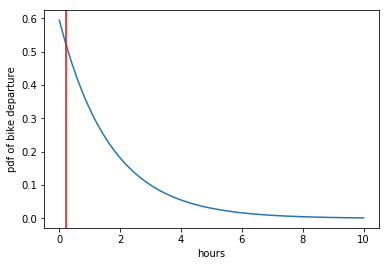

In [405]:
plt.plot(t, pdf)
plt.axvline(y_test.iloc[a], c='red')
plt.xlabel('hours')
plt.ylabel('pdf of bike departure')

In [406]:
cdf = scs.expon(scale=y_pred[a]).cdf(t)

Text(0, 0.5, 'probability bike has departed')

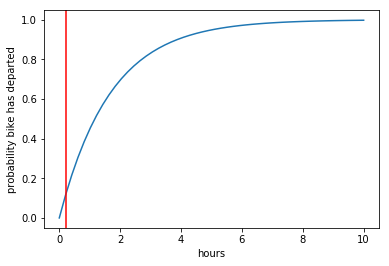

In [408]:
plt.plot(t, cdf)
plt.axvline(y_test.iloc[a], c='red')
plt.xlabel('hours')
plt.ylabel('probability bike has departed')

In [366]:
#chance of outcome at index 1, given the distribution predicted for this bike
scs.expon(scale=y_pred[a]).cdf(y_test.iloc[a])

0.12825570798370856

In [367]:
prob_all_outcomes = [scs.expon(scale=y_pred[i]).cdf(y_test.iloc[i]) for i in range(len(y_pred))]
prob_all_outcomes = np.array(prob_all_outcomes)

In [368]:
prob_space = np.linspace(0,1)

In [369]:
fraction_predicted = [(prob_all_outcomes<p).sum()/len(prob_all_outcomes) for p in prob_space]

Text(0, 0.5, 'Fraction of idles with this outcome')

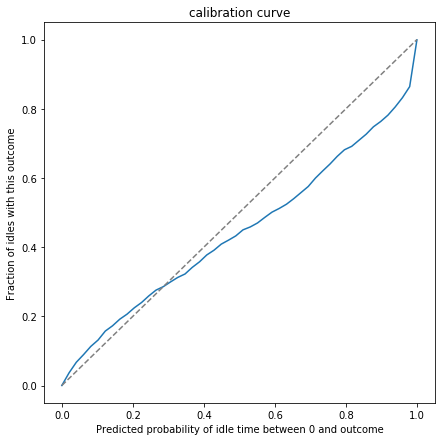

In [370]:
fig,ax = plt.subplots(figsize=(7,7))
ax.plot(prob_space, fraction_predicted)
ax.plot([0,1],[0,1], c="grey", linestyle='dashed')
ax.set_title("calibration curve")
ax.set_xlabel("Predicted probability of idle time between 0 and outcome")
ax.set_ylabel("Fraction of idles with this outcome")

In [371]:
#interval of bike arrivals in the vicinity of bike 'a'
model_neighbors.get_mean_interarrival_time(test_geodf.iloc[a].geolocation, test_geodf.iloc[a].local_time_start, geodf, 1000)

0.0625

In [372]:
y_pred[a]

1.6837575197382342

In [403]:
#probability bike 'a' is still there after 0.5 hours (1-prob it has departed)
1 - scs.expon(scale=y_pred[a]).cdf(.5)

0.2569224553416101

In [373]:
rss = ((y_test.values - y_pred) ** 2).sum()
tss = ((y_test.values - y_test.values.mean()) ** 2).sum()
r2 = 1 - (rss/tss)

In [374]:
r2

0.018259672281334405